# Laboratorium 1 Przetwarzanie danych

## 0. Wstęp i inicjalizacja projektu

### 0.1 Wstęp

Celem zadania jest przeanalizowanie zbioru danych "Polish Companies Bankruptcy", który zawiera informacje na temat polskich przedsiębiorstw, które zbankrutowały na przestrzeni pięciu lat. Po wstępnej analizie przeprowadzona zostanie redukcja wymiarów przy użyciu dwóch metod: PCA oraz t-SNE.

Następnie dane zostaną poddane procesowi oczyszczania, obejmującemu normalizację / standaryzację, usunięcie wartości odstających oraz uzupełnienie brakujących danych.

W kolejnej części projektu zostaną wytrenowane dwa klasyfikatory, których celem będzie predykcja upadłości firm. Ostatecznie uzyskane wyniki zostaną poddane analizie końcowej, mającej na celu ocenę skuteczności zastosowanych metod.

### 0.2 Inicjalizacja projektu

Do przeprowadzenia projektu konieczne są biblioteki:
1. ucimlrepo - pobranie zbioru danych
2. pandas - analiza tabelaryczna danych
3. numpy - operacje na macierzach
4. matplotlib/seaborn - wizualizacja analizy danych w formie wykresów
5. sklearn - Knn

In [ ]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from scipy import stats
from imblearn.over_sampling import SMOTE, RandomOverSampler
import xgboost as xgb

In [3]:
polish_companies_bankruptcy = fetch_ucirepo(id=365) 

Do analizy zostały przygotowane trzy zmienne przechowujące dane odnośnie zbioru
1. X - dane polskich przedsiębiorstw
2. y - etykiety czy przedsiębiorstwo zbankrutowało
3. pcb_df - pandas dataframe ujmujący X oraz y 

In [8]:
X = polish_companies_bankruptcy.data.features 
y = polish_companies_bankruptcy.data.targets 
pcb_df = polish_companies_bankruptcy.data.original

## 1. Badanie cech zbioru wraz z wizualizacją.

Ze względu na wysoką liczbę atrybutów zbioru, atrybuty nie zostaną precyzyjnie nazwane. Zostanie zachowana konwencja $A_n$ opisująca kolejne atrybuty.

In [225]:
polish_companies_bankruptcy.variables

name     role        type demographic description units missing_values
0    year  Feature     Integer        None        None  None             no
1      A1  Feature  Continuous        None        None  None             no
2      A2  Feature  Continuous        None        None  None             no
3      A3  Feature  Continuous        None        None  None             no
4      A4  Feature  Continuous        None        None  None            yes
..    ...      ...         ...         ...         ...   ...            ...
61    A61  Feature  Continuous        None        None  None            yes
62    A62  Feature  Continuous        None        None  None             no
63    A63  Feature  Continuous        None        None  None            yes
64    A64  Feature  Continuous        None        None  None            yes
65  class   Target     Integer        None        None  None             no

[66 rows x 7 columns]

Zbiór posiada wysoką zawartość danych. Znajduje się w nim 43 405 rekordów oraz 65 atrybutów z etykietami w formie dyskretnej (0/1).

Analiza danych manualnie jest niemożliwa ze względu na złożoność oraz ilość danych. Narzuca to konieczność precyzyjnego rozpatrzenia ogólnych cech charakterystycznych zbioru takich jak średnia, mediana, odchylenia standardowe oraz sugeruje to redukcje wymiarów w celu uproszczenia procesu analizy.

In [226]:
pcb_df

year        A1       A2        A3       A4        A5       A6  \
0         1  0.200550  0.37951  0.396410  2.04720   32.3510  0.38825   
1         1  0.209120  0.49988  0.472250  1.94470   14.7860  0.00000   
2         1  0.248660  0.69592  0.267130  1.55480   -1.1523  0.00000   
3         1  0.081483  0.30734  0.458790  2.49280   51.9520  0.14988   
4         1  0.187320  0.61323  0.229600  1.40630   -7.3128  0.18732   
...     ...       ...      ...       ...      ...       ...      ...   
43400     5  0.012898  0.70621  0.038857  1.17220  -18.9070  0.00000   
43401     5 -0.578050  0.96702 -0.800850  0.16576  -67.3650 -0.57805   
43402     5 -0.179050  1.25530 -0.275990  0.74554 -120.4400 -0.17905   
43403     5 -0.108860  0.74394  0.015449  1.08780  -17.0030 -0.10886   
43404     5 -0.105370  0.53629 -0.045578  0.91478  -56.0680 -0.10537   

             A7       A8       A9  ...       A56       A57      A58       A59  \
0      0.249760  1.33050  1.13890  ...  0.121960  0.397180  0.87804  0.001924   
1      0.258340  0.99601  1.69960  ...  0.121300  0.420020  0.85300  0.000000   
2      0.309060  0.43695  1.30900  ...  0.241140  0.817740  0.76599  0.694840   
3      0.092704  1.86610  1.05710  ...  0.054015  0.142070  0.94598  0.000000   
4      0.187320  0.63070  1.15590  ...  0.134850  0.484310  0.86515  0.124440   
...         ...      ...      ...  ...       ...       ...      ...       ...   
43400  0.013981  0.41600  1.67680  ...  0.020169  0.043904  1.01220  1.259400   
43401 -0.578050 -0.40334  0.93979  ... -0.064073  1.482000  1.06410 -0.018084   
43402 -0.154930 -0.26018  1.17490  ...  0.148880  0.548240  0.85112 -0.522430   
43403 -0.109180  0.12531  0.84516  ... -0.183200 -1.167700  1.18320  6.092400   
43404 -0.109940  0.86460  0.95040  ... -0.052186 -0.227250  1.05220  0.003196   

            A60      A61      A62     A63       A64  class  
0        8.4160   5.1372   82.658  4.4158   7.42770      0  
1        4.1486   3.2732  107.350  3.4000  60.98700      0  
2        4.9909   3.9510  134.270  2.7185   5.20780      0  
3        4.5746   3.6147   86.435  4.2228   5.54970      0  
4        6.3985   4.3158  127.210  2.8692   7.89800      0  
...         ...      ...      ...     ...       ...    ...  
43400   13.4720  12.4320   49.117  7.4313   2.27990      1  
43401  110.7200  44.7590   81.220  4.4940   5.13050      1  
43402    9.8526   3.4892  207.870  1.7559   9.95270      1  
43403   13.8860   6.0769   83.122  4.3911   0.95575      1  
43404    7.7332   4.7174  136.850  2.6672   2.79270      1  

[43405 rows x 66 columns]

Zbiór danych posiada bardzo zróżnicowane wartości rzeczywiste, które znacznie różnią się od siebie.

Przykładowo dla A3 kolejno najniższa i najwyższa wartość wynosi 5.4 oraz 28.3, gdzie dla A4 wynoszą -0.4 oraz 53443.0. Wskazuje to na konieczność skalowania lub normalizowania danych podczas dalszych analiz liczbowych.

In [227]:
X.describe()

year            A1            A2            A3            A4  \
count  43405.000000  43397.000000  43397.000000  43397.000000  43271.000000   
mean       2.939753      0.035160      0.590212      0.114431      6.314702   
std        1.283975      2.994109      5.842748      5.439429    295.434425   
min        1.000000   -463.890000   -430.870000   -479.960000     -0.403110   
25%        2.000000      0.003429      0.268980      0.021521      1.049500   
50%        3.000000      0.049660      0.471900      0.196610      1.569800   
75%        4.000000      0.129580      0.688320      0.403390      2.787450   
max        5.000000     94.280000    480.960000     28.336000  53433.000000   

                 A5            A6            A7            A8            A9  \
count  4.331600e+04  43397.000000  43397.000000  43311.000000  43396.000000   
mean  -3.853480e+02     -0.056107      0.093478     12.640779      2.652166   
std    6.122797e+04      7.201326      5.713075    505.894281     62.932732   
min   -1.190000e+07   -508.410000   -517.480000   -141.410000     -3.496000   
25%   -4.908000e+01      0.000000      0.005776      0.430275      1.018500   
50%   -1.034500e+00      0.000000      0.059634      1.070400      1.195350   
75%    5.063425e+01      0.089446      0.150880      2.615700      2.062500   
max    1.250100e+06    543.250000    649.230000  53432.000000   9742.300000   

       ...           A55           A56           A57           A58  \
count  ...  4.340400e+04  4.327800e+04  43398.000000  4.332100e+04   
mean   ...  7.672346e+03 -2.621959e+01     -0.010510  3.002644e+01   
std    ...  7.005349e+04  5.327862e+03     13.674072  5.334454e+03   
min    ... -1.810000e+06 -1.108300e+06  -1667.300000 -1.986900e+02   
25%    ...  2.755425e+01  9.348500e-03      0.014649  8.753200e-01   
50%    ...  1.088350e+03  5.294300e-02      0.119670  9.509600e-01   
75%    ...  4.993325e+03  1.290975e-01      0.284605  9.926400e-01   
max    ...  6.120000e+06  2.931500e+02    552.640000  1.108300e+06   

                A59           A60            A61           A62           A63  \
count  43398.000000  4.125300e+04   43303.000000  4.327800e+04  43271.000000   
mean       1.333288  4.481067e+02      17.033202  1.502521e+03      9.343074   
std      122.104445  3.234518e+04     553.049406  1.393023e+05    124.177354   
min     -327.970000 -1.244000e+01     -12.656000 -2.340000e+06     -1.543200   
25%        0.000000  5.545500e+00       4.510150  4.214400e+01      3.097650   
50%        0.006366  9.791700e+00       6.636300  7.132600e+01      5.087600   
75%        0.236052  2.018100e+01      10.394500  1.172200e+02      8.598850   
max    23853.000000  4.818700e+06  108000.000000  2.501600e+07  23454.000000   

                 A64  
count   42593.000000  
mean       72.796105  
std      2369.744596  
min    -10677.000000  
25%         2.176800  
50%         4.282500  
75%         9.776200  
max    294770.000000  

[8 rows x 65 columns]

Rozkład klas w zbiorze jest zdecydownie nierównomierny. Przedsiębiorstwa, które zbankrutowały wynoszą zaledwie 2091, a te, które nie zbankrutowały 41314.

class
0        41314
1         2091
Name: count, dtype: int64


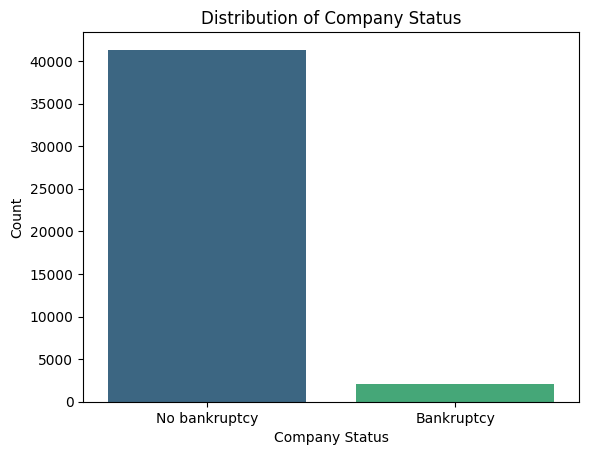

In [228]:
sns.barplot(x=["No bankruptcy", "Bankruptcy"], y=y.value_counts().values, hue=["No bankruptcy", "Bankruptcy"] ,palette="viridis")

plt.xlabel("Company Status")
plt.ylabel("Count")
plt.title("Distribution of Company Status")

print(y.value_counts())
plt.show()

Fakt bankructwa nie jest zależny od roku.  Atrybut ten został zinterpretowany jako atrybut służący do grupowania. Co roku około 4-7% firm bankrutuje

In [229]:
grouped_df = pcb_df.groupby("year")["class"].value_counts().unstack().fillna(0)
grouped_df["%"] = grouped_df[1] / (grouped_df[0] + grouped_df[1]) * 100
grouped_df

class      0    1         %
year                       
1       6756  271  3.856553
2       9773  400  3.931977
3      10008  495  4.712939
4       9277  515  5.259395
5       5500  410  6.937394

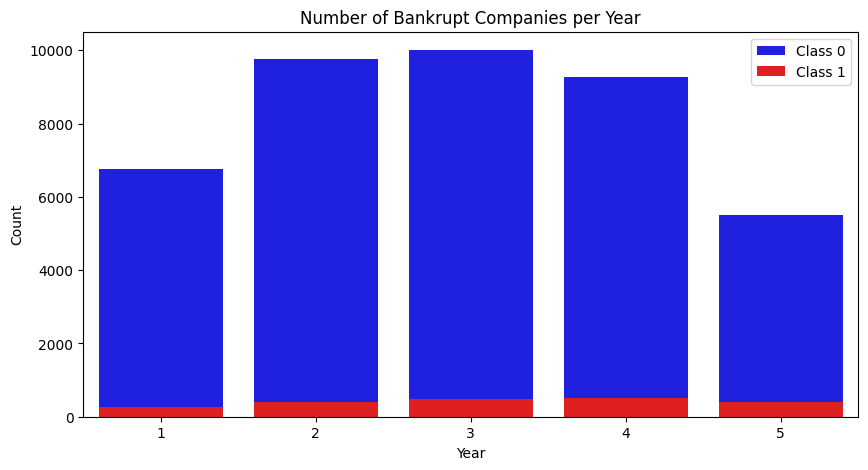

In [230]:
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped_df, x="year", y=0, color="blue", label="Class 0")
sns.barplot(data=grouped_df, x="year", y=1, color="red", label="Class 1")

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of Bankrupt Companies per Year")
plt.legend()
plt.show()

Zbiór posiada wiele brakujących danych w poszczególnych atrybutach. Występuje aż 28 atrybutów spośród 66, które posiadają brakujące wartości.

In [231]:
polish_companies_bankruptcy.variables["missing_values"].where(polish_companies_bankruptcy.variables["missing_values"] == 'yes').dropna().count()

28

Dalsza analiza ukazuje, iż istnieje różnica w dystrybucji brakujących danych, którą należy zbadać w wartościach procentowych, aby była łatwiejsza do interpretacji

In [232]:
missing_values_count = X.isnull().sum().sort_values(ascending=False)
missing_values_count

A37     18984
A21      5854
A27      2764
A60      2152
A45      2147
        ...  
A14         8
A57         7
A59         7
A55         1
year        0
Length: 65, dtype: int64

Analiza procentowego udziału brakujących danych wykazała, że:

1. Atrybut A37 jest nieprzydatny, ponieważ brakuje w nim aż 43,7% wartości. Uzupełnienie tych danych dowolną techniką mogłoby negatywnie wpłynąć na skuteczność modeli predykcyjnych.
2. Atrybut A21 zawiera 13,5% brakujących wartości. Choć jest to znacznie mniejsza wartość niż w przypadku A37, estymowanie brakujących danych może obniżyć jakość predykcji, zwłaszcza że zbiór zawiera wiele innych atrybutów, które mogą dostarczyć istotnych informacji.
3. Atrybuty z brakami na poziomie 6,4%–4,9% można rozważyć jako kandydatów do uzupełnienia, ponieważ ich częściowa rekonstrukcja może być korzystna dla jakości modelu.
4. Atrybuty z brakami na poziomie 2,1%–0,002% są dobrymi kandydatami do uzupełnienia, ponieważ brakujące wartości stanowią niewielką część zbioru i ich imputacja może minimalizować straty informacyjne.

In [233]:
(missing_values_count / len(X) * 100)

A37     43.736897
A21     13.486925
A27      6.367930
A60      4.957954
A45      4.946435
          ...    
A14      0.018431
A57      0.016127
A59      0.016127
A55      0.002304
year     0.000000
Length: 65, dtype: float64

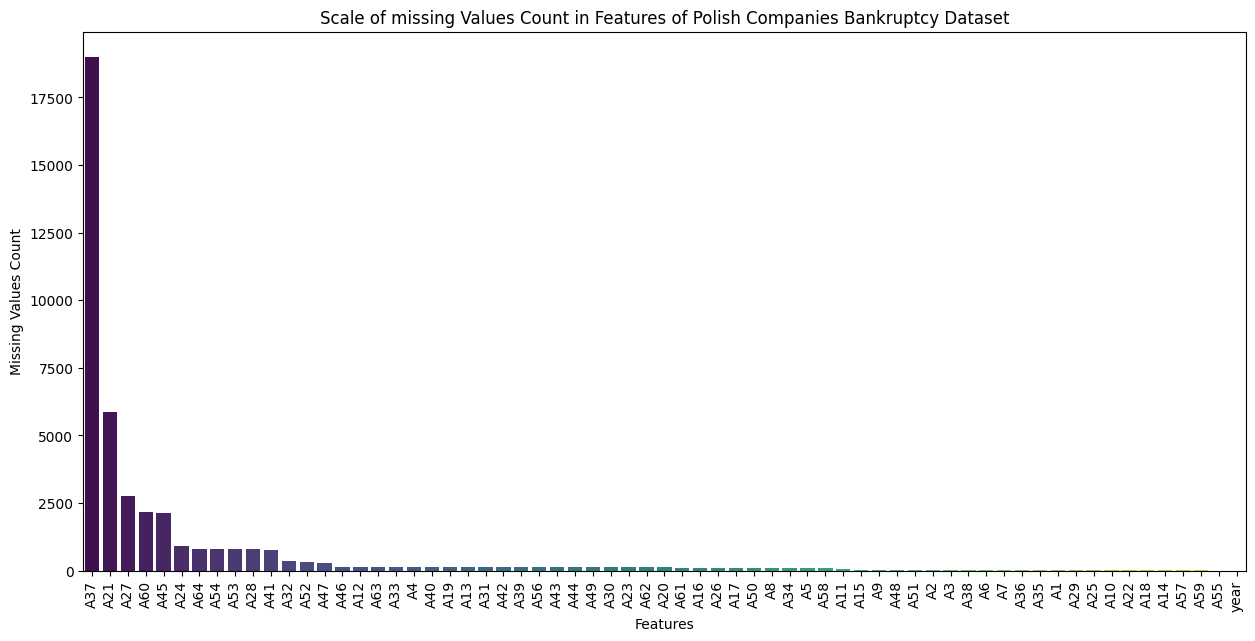

In [234]:
plt.figure(figsize=(15,7))
sns.barplot(x=missing_values_count.index, y=missing_values_count, palette='viridis', hue=missing_values_count.index, legend=False)
plt.ylabel('Missing Values Count')
plt.xlabel('Features')
plt.title('Scale of missing Values Count in Features of Polish Companies Bankruptcy Dataset')
plt.xticks(rotation=90)
plt.show()
# zdecydowałem się nie tworzyć skali logarytmicznej, gdyż nie interesują nas dokładne wartości atrybutów o niskiej liczbie, tylko skala tych z wysoką liczbą

Analiza średnich bez skalowania mogłaby prowadzić do błędnych wniosków ze względu na różnice w skalach poszczególnych atrybutów. Dlatego zdecydowano się na ich standaryzację, a następnie posortowanie wyników według wartości bezwzględnej różnicy między klasami.

Najbardziej wyróżniającymi się atrybutami są A55, A32, A15, A27, A43, A44, A5,

In [235]:
pcb_mean = pcb_df.drop("year", axis=1).groupby("class").mean()
scaler = StandardScaler()
# usiłowałem po prostu scaler.fit_transform(pcb_mean) ale konwertowało dataframe na numpy, więc znalazłem takie rozwiązanie
pcb_mean_scaled = pd.DataFrame(
    scaler.fit_transform(pcb_mean.T).T,
    index=pcb_mean.index, 
    columns=pcb_mean.columns
)
pcb_mean_differences = abs(pcb_mean_scaled.loc[0] - pcb_mean_scaled.loc[1]).sort_values(ascending=False)
pcb_mean_differences.head(10)

A55    6.766602
A32    5.631767
A15    2.861485
A27    1.026039
A43    0.797983
A44    0.634725
A5     0.413390
A60    0.265898
A47    0.234969
A20    0.132018
dtype: float64

C:\Users\mikja\AppData\Local\Temp\ipykernel_4588\3876504463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pcb_mean_differences.index, y=pcb_mean_differences, palette='viridis')


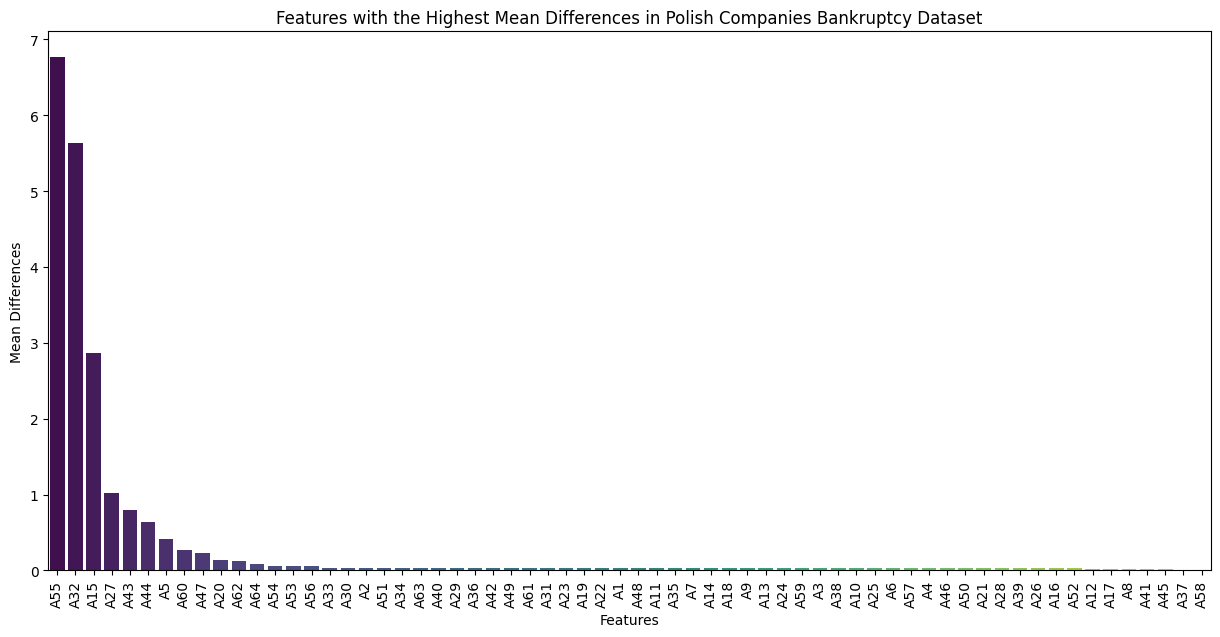

In [236]:
plt.figure(figsize=(15,7))
sns.barplot(x=pcb_mean_differences.index, y=pcb_mean_differences, palette='viridis')
plt.ylabel('Mean Differences')
plt.xlabel('Features')
plt.title('Features with the Highest Mean Differences in Polish Companies Bankruptcy Dataset')
plt.xticks(rotation=90)
plt.show()

Analogicznie dokonano analizy mediany. Wyróżnia ona atrybuty A55, A15, A62, A32, A43

In [237]:
pcb_median = pcb_df.drop("year", axis=1).groupby("class").median()
scaler = StandardScaler()
pcb_median_scaled = pd.DataFrame(
    scaler.fit_transform(pcb_median.T).T,
    index=pcb_median.index,
    columns=pcb_median.columns
)
pcb_median_differences = abs(pcb_median_scaled.loc[0] - pcb_median_scaled.loc[1]).sort_values(ascending=False)
pcb_median_differences.head(10)

A55    5.578522
A15    3.001299
A62    0.841747
A32    0.830343
A43    0.632385
A5     0.436760
A44    0.281864
A20    0.233677
A47    0.200835
A61    0.041225
dtype: float64

C:\Users\mikja\AppData\Local\Temp\ipykernel_4588\653656724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pcb_median_differences.index, y=pcb_median_differences, palette='viridis')


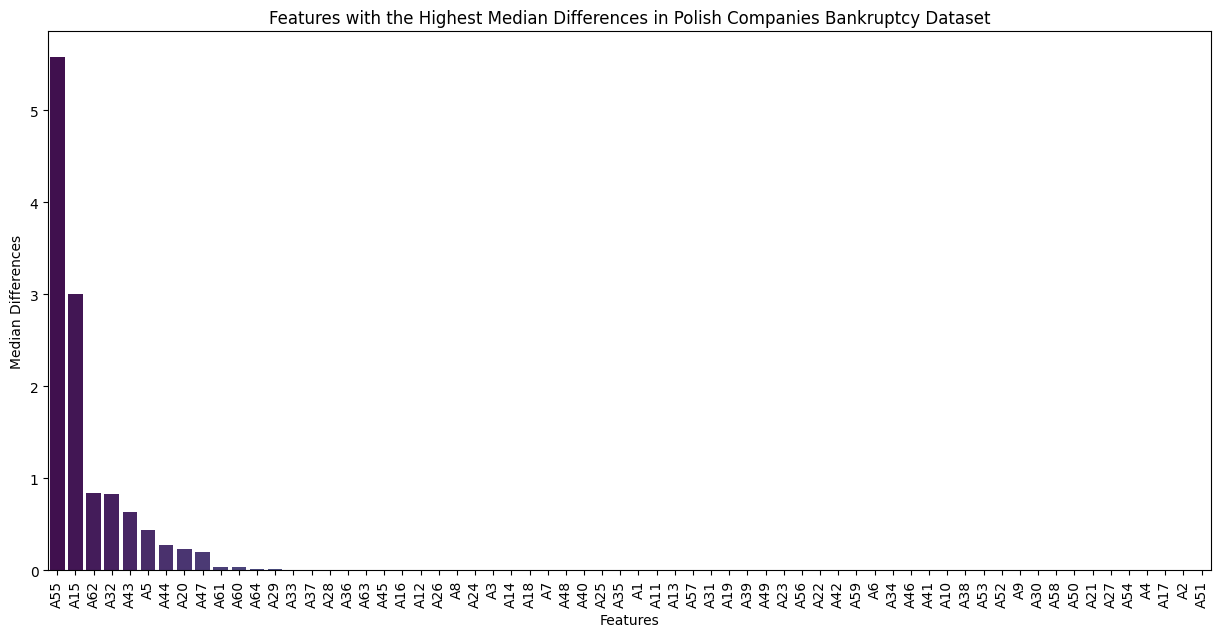

In [238]:
plt.figure(figsize=(15,7))
sns.barplot(x=pcb_median_differences.index, y=pcb_median_differences, palette='viridis')
plt.ylabel('Median Differences')
plt.xlabel('Features')
plt.title('Features with the Highest Median Differences in Polish Companies Bankruptcy Dataset')
plt.xticks(rotation=90)
plt.show()

Podjęto próbę wizualizacji danych za pomocą boxplot, wybierając 10 cech o największej wariancji i stosując standaryzację. Mimo to wartości odstające były zbyt ekstremalne, co uniemożliwiało czytelną interpretację.

Zdecydowano się w celu analizy dokonać chwilowego skalowania oraz IQR aby móc zwizualizować w lepszy sposób dane.

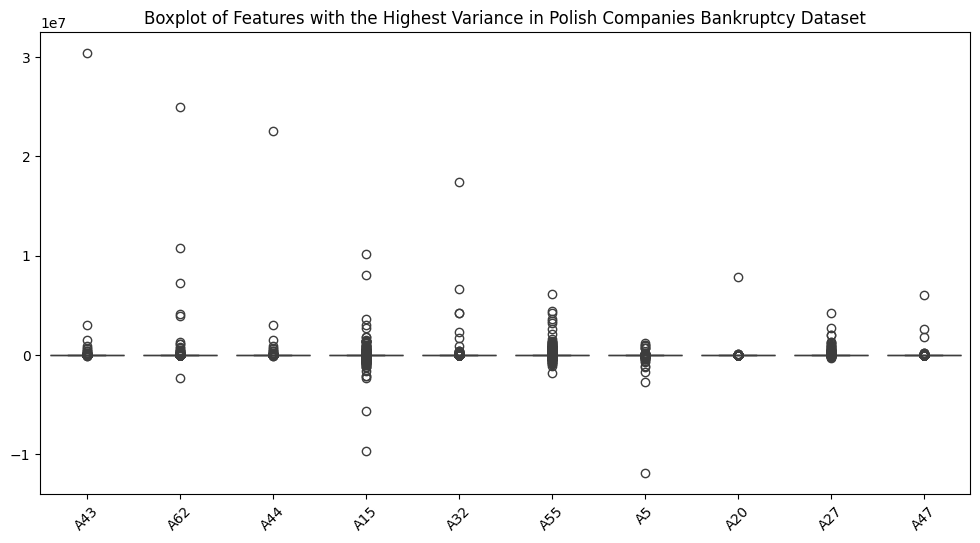

In [239]:
selected_columns = pcb_df.var().sort_values(ascending=False).head(10).index
subset_df = pcb_df[selected_columns]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_df)
plt.xticks(rotation=45)
plt.title("Boxplot of Features with the Highest Variance in Polish Companies Bankruptcy Dataset")
plt.show()

In [240]:
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

Mimo zastosowania metody IQR, nadal obserwujemy liczne wartości odstające. Świadczy to o ekstremalnym rozkładzie danych. Nawet po obcięciu skrajnych wartości nadal występują znaczne różnice. 

Można także zaobserwować, iż rozstęp międzykwartylowy jest podobny dla większości cech, ponieważ wysokość "pudełek" jest stosunkowo podobna między cechami. Kolejną obserwacją jest brak wyrównania median do 0 mimo zastosowania Scalera. Oznacza to że niektóre cechy mają silną asymetrię, czyli różnią się od rozkładu normalnego odbiegając w jedną ze stron, a posiadając dużo outlierów z drugiej.

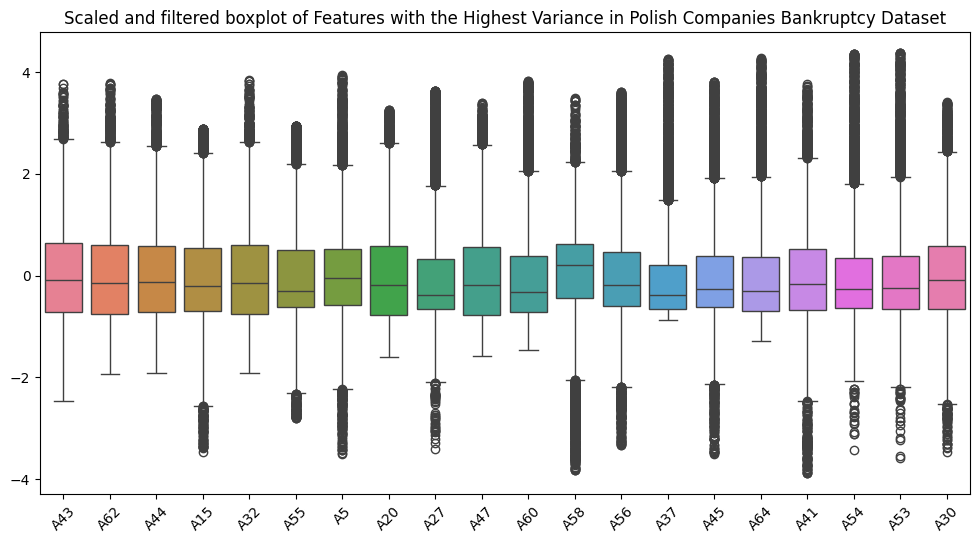

In [241]:
selected_columns = pcb_df.var().sort_values(ascending=False).head(20).index
subset_df = pcb_df[selected_columns]

filtered_df = remove_outliers_iqr(subset_df)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_df)
scaled_df = pd.DataFrame(scaled_data, columns=subset_df.columns)


plt.figure(figsize=(12, 6))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=45)
plt.title("Scaled and filtered boxplot of Features with the Highest Variance in Polish Companies Bankruptcy Dataset")
plt.show()

Skalowanie oraz filtrowanie danych umożliwiło dogodną analizę zbioru danych za pomocą PairGrid.

Histogramy na przekątnych ukazują że rozkłady atrybutów A43, A62, A44, A32 po skalowaniu i filtrowaniu przypominają rozkłady normalne, lecz pozostałe nie posiadają takich zależności

Pary zmiennych jak A43, A44 oraz A62, A32 wskazują, iż niektóre atrybuty posiadają bardzo silną zależnośc liniową.



C:\Users\mikja\AppData\Local\Temp\ipykernel_4588\2222260151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_scaled_df["class"] = pcb_df["class"]


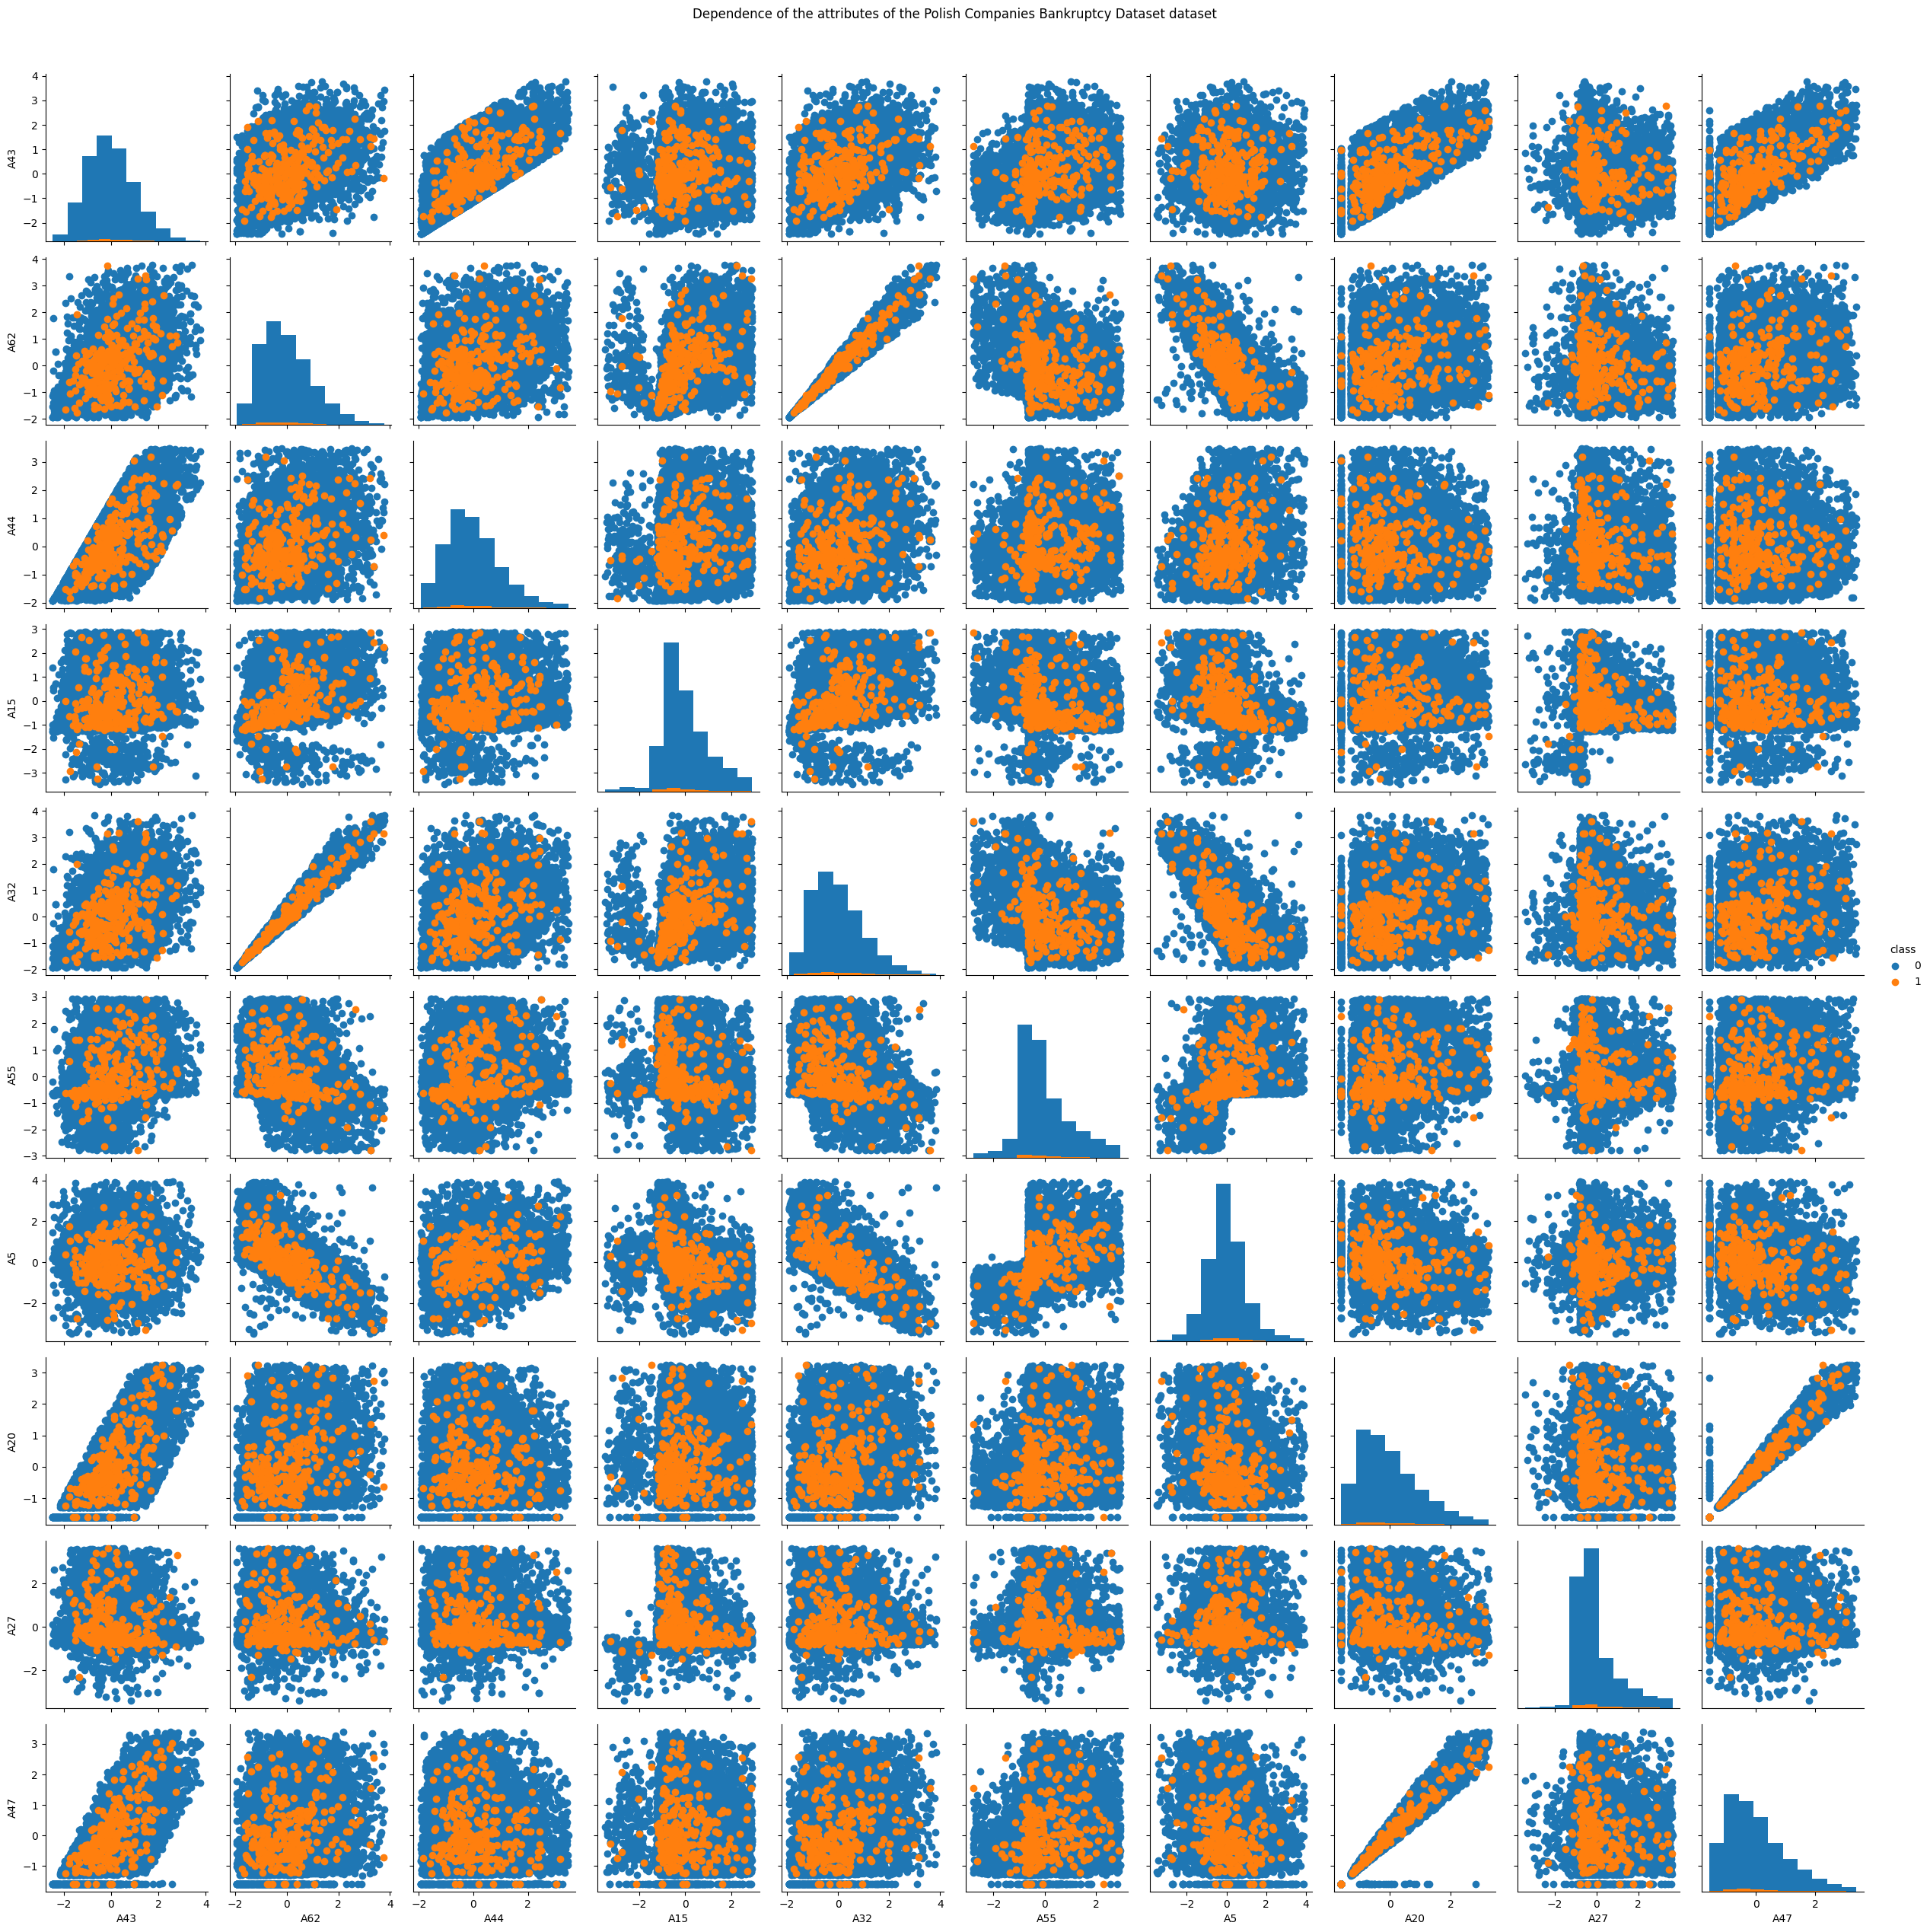

In [242]:
selected_scaled_df = scaled_df.iloc[:, :10]
selected_scaled_df["class"] = pcb_df["class"]

iris_PairGrid = sns.PairGrid(selected_scaled_df, hue="class")
plt.suptitle("Dependence of the attributes of the Polish Companies Bankruptcy Dataset dataset", y=1.02)
iris_PairGrid.map_diag(plt.hist)
iris_PairGrid.map_offdiag(plt.scatter)
iris_PairGrid.add_legend()

Porównanie dwóch poniższych wykresów ukazuje konieczność przeprowadzenia skalowania oraz filtrowania danych przed ich głębszą wizualną analizą.
Pierwszy poniższy wykres nie ukazuje silnych zależności liniowych, gdyby pominąć linię regresji, z kolei drugi ukazuje bardzo silną liniową zależność zmiennych A62 oraz A32.

Text(0.5, 1.02, 'Dependency of A32 and A62 on unscaled and unfiltered data')

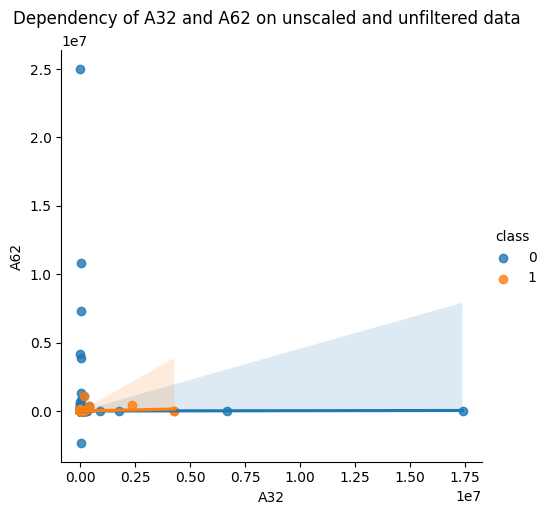

In [243]:
_ = sns.lmplot(x="A32", y="A62", data=pcb_df, hue="class", fit_reg=True)
plt.suptitle("Dependency of A32 and A62 on unscaled and unfiltered data", y=1.02)

Text(0.5, 1.02, 'Dependency of A32 and A62 on scaled and filtered data')

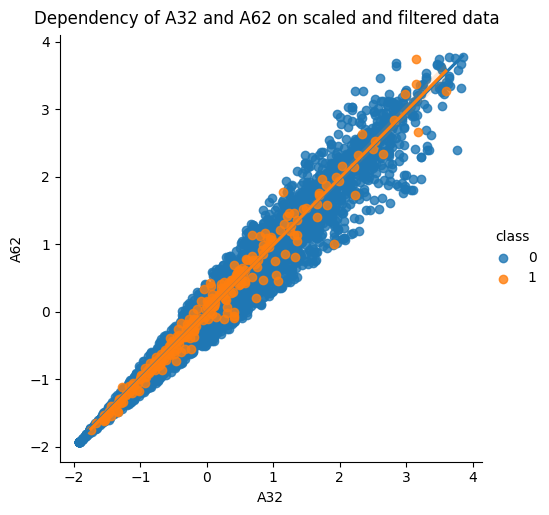

In [244]:
_ = sns.lmplot(x="A32", y="A62", data=selected_scaled_df, hue="class", fit_reg=True)
plt.suptitle("Dependency of A32 and A62 on scaled and filtered data", y=1.02)

Macierz korelacji ukazuje, iż zmienne "A49", "A51", "A56" posiadają wysokie korelacje z poszczególnymi innymi atrybutami.

Wykres ukazuje śladowe wysokie wartości dla "A58" oraz "A62".

Pozostałe atrybuty nie są skorelowane między sobą, może to utrudnić redukcję wymiarów PCA. 

<Axes: >

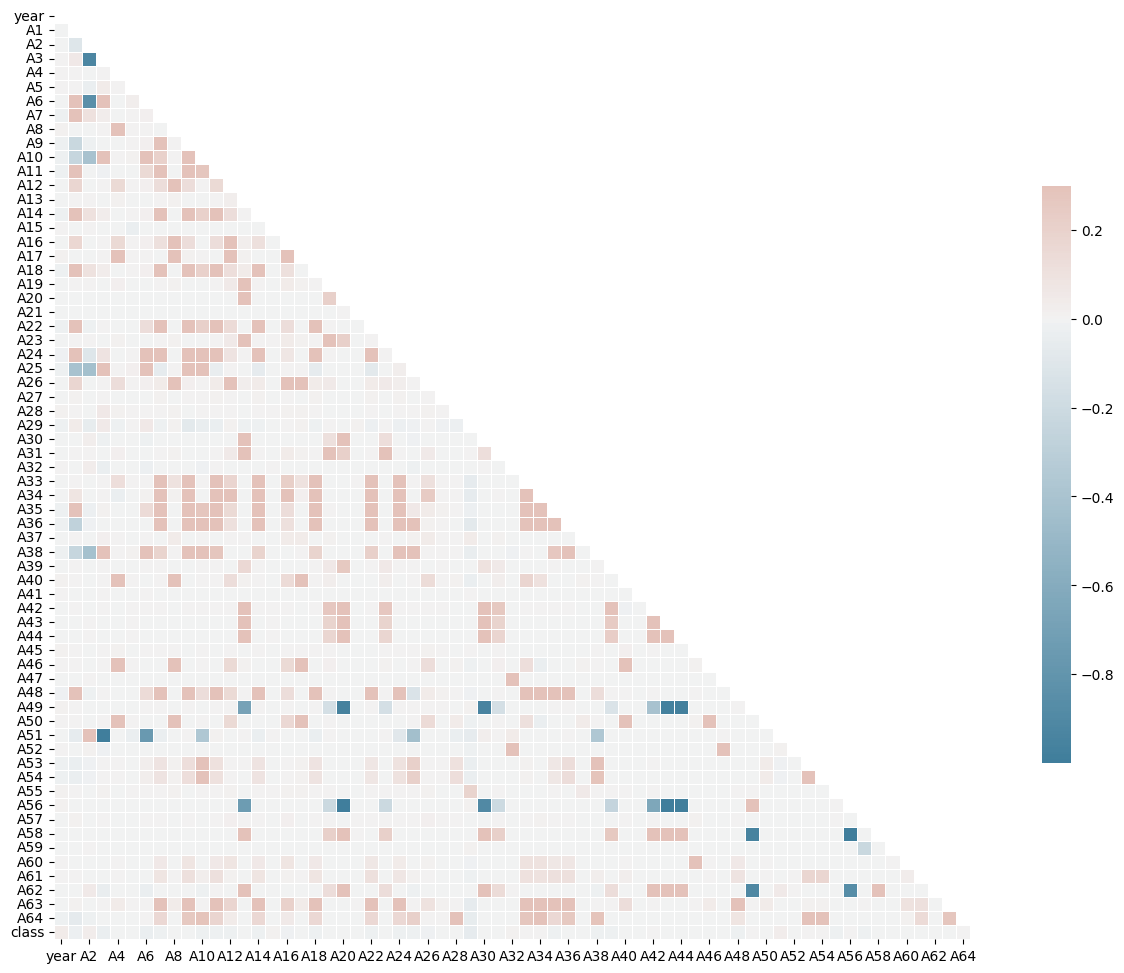

In [245]:
# based on https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = pcb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 2. Preprocessing danych
#### Modyfikacja składowych (atrybutów) zbioru - transformacja, czyszczenie danych, brakujące dane, standaryzacja / normalizacja, problem wartości odstających (outlierów). Analiza oraz porównanie różnych metod.

#### Usunięcie kolumn

Kolumny A37 oraz A21 kolejno nieposiadające 43.74% oraz 13.49% danych zostały odrzucone, ponieważ uzupełnianie ich wartości mołoby dać niedokładne wyniki. Dodatkowo kolumna year została zinterpretowana jako atrybut służący do grupowania, nie wnoszący większych trendów do danych.

In [9]:
preprocessed_df = X.drop(["A37", "A21", "year", "A27"], axis=1)

#### Usunięcie wartości ekstremalnych

Ze względu na to, że zmienne nie posiadają rozkładu normalnego, tylko bardzo zróżnicowane dystrybucje lepiej skorzystać z IQR, zamiast Z-score, który jest rekomendowany do danych o rozkładzie normalnym 

In [10]:
def remove_outliers_iqr(df, threshhold=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - threshhold * IQR)) | (df > (Q3 + threshhold * IQR))).any(axis=1)]

Logarytmowanie danych  zostało odrzucone ze względu na obecność licznych wartości ujemnych, co prowadziło do powstawania wielu wartości NaN.

Alternatywnie, możliwe byłoby znalezienie najmniejszej wartości w zbiorze i dodanie jej do wszystkich obserwacji, aby posiadały wartości dodatnie, aczkolwiek zdecydowano, że mogłoby to spowodować nienaturalne przeksształcenia danych, które zatracą ich ważne cechy - np. odległości ppunktów dla danych atrybutów.

In [11]:
# preprocessed_df = np.log1p(preprocessed_df) - zrezygnowano z logarytmowania, ponieważ mamy pełno wartości ujemnych.
# potencjalnie można byłoby tu znaleźć najniższą wartość w datasecie -> dodać ją do każdej innej, ale lepiej zastosować skalowanie

In [12]:
preprocessed_df["class"] = y

Proces usuwania wartości odstających został przeprowadzony osobno dla każdej klasy, aby przez generalizację nie usunąć nadmiernej ilości rekordów klasy mniej reprezentowanej. 

(**na marginesie** Z perspektywy czasu stwierdzam, iż można było nie usuwać tych wartości - bardzo możliwe iż z pewnych względów rekordy dla klasy 1 były tak skrajnie odstające - mogły właśnie tym ukazywać bankructwo. Ta decyzja ma swoje wady i zalety, lecz finalnie zdecydowałem się usunąć wartości odstające, aby nauczyć się jak można to robić i parametryzować threshold)

In [13]:
df_class_0 = preprocessed_df[preprocessed_df["class"] == 0]
df_class_1 = preprocessed_df[preprocessed_df["class"] == 1]

Wybrano próg 40 dla usuwania wartości odstających, co znacznie przekracza standardową wartość 1.5 w metodzie IQR. Decyzja ta została podjęta, aby ograniczyć liczbę usuniętych obserwacji i uniknąć nadmiernej utraty danych.

In [14]:
df_class_0_clean = remove_outliers_iqr(df_class_0, threshhold=40)
df_class_1_clean = remove_outliers_iqr(df_class_1, threshhold=40)

In [15]:
preprocessed_df = pd.concat([df_class_0_clean, df_class_1_clean]).reset_index(drop=True)

Imputacja brakujących danych

In [16]:
preprocessed_df["class"].value_counts()

class
0    36990
1     1813
Name: count, dtype: int64

Dla firm zbankrutowanych brakuje aż 715 wartości A27 spośród 2000 rekordów. Estymacja ich na podstawie klasy może być bardzo nieadekwatna, więc lepiej dodać ją do kolumn usuniętych.

*ukazane wcześniej*

missing_values_count.head()

A27    715

dtype: int64

Brakujące wartości dla A60 oraz A45 oraz kolumn z niższą wartością brakujących wartości mogą być uzupełnione medianą, jako iż stanowią w majgorszym przypadku 3,2% reprezentantów przedsiębiorstw zbankrutowanych.

In [17]:
missing_values_count = preprocessed_df[preprocessed_df['class'] == 1].isnull().sum().sort_values(ascending=False)
missing_values_count.head(10)

A45    114
A60    114
A64     43
A28     43
A53     43
A54     43
A11     34
A32      6
A34      3
A16      3
dtype: int64

In [18]:
mask = preprocessed_df['class'] == 1
preprocessed_df.loc[mask] = preprocessed_df.loc[mask].apply(lambda x: x.fillna(x.median()))

Zewnętrzne źródła rekomendowały technikę dodania kolumny "XX_missing", w która poziadała wartości "0" lub "1" w zależności od tego czy dana została uzupełniona, czy jest oryginalną wartością. Finalnie technika ta zdecydowania pogorszyla klasyfikator, więc zrezygnowano z niej.

Lepszym rozwiązaniem byłoby dodanie nowych atrybutów przez zaaplikowanie pewnej funkcji na parach atrybutów. (*niestety wiedza została zdobyta na wykładzie dzień przed oddaniem listy, więc nie posiadałem czasu na przetestowanie tego*)

In [19]:
# missing_cols = ["A60", "A45", "A24", "A41", "A54", "A53", "A28", "A64"]

# for col in missing_cols:
#     if preprocessed_df[col].isna().sum() > 0:
#         preprocessed_df[f"{col}_missing"] = preprocessed_df[col].isna().astype(int)
        
# for col in preprocessed_df.columns:
#     if preprocessed_df[col].isna().sum() > 0:
#         preprocessed_df[col].fillna(preprocessed_df[col].median(), inplace=True)

W najgorszym przypadku, dla "A60" oraz "A45" brakuje zaledwie 3.6%.

Wartości dla kolejnych atrybutów wynoszą 2%.

Ze względu na te informacje, dane można uzupełnić wartością mediany, jako, iż w dalszym ciągu posiadamy wielu lekkich outlierów.

In [20]:
missing_values_count = preprocessed_df[preprocessed_df['class'] == 0].isnull().sum().sort_values(ascending=False)
missing_values_count.head(10)

A60    1422
A45    1421
A24     797
A41     647
A54     542
A53     542
A28     542
A64     542
A32     243
A52     232
dtype: int64

In [21]:
mask = preprocessed_df['class'] == 0
preprocessed_df.loc[mask] = preprocessed_df.loc[mask].apply(lambda x: x.fillna(x.median()))

Przetestowano uzupełnianie danych średnią oraz medianą, co nie miało większego wpływu na jakość klasyfikatorów, lecz ze względu na liczne wartości odstające zdecydowano się pozostać przy medianie.

standaryzacja / normalizacja

Dane zostały poddane standaryzacji który przekształca je tak, aby miały średnią 0 i odchylenie standardowe 1.  Na końcu sprawdzono statystyki opisowe, aby zweryfikować efekt transformacji. Dane te nie zostały użyte do modelu, lecz do PCA. Osobne skalowanie odbywa się na wysokości podziału danych.

In [22]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(preprocessed_df.drop("class", axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=preprocessed_df.columns[:-1])
scaled_df["class"] = preprocessed_df["class"]
scaled_df.describe()

A1            A2            A3            A4            A5  \
count  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04   
mean  -2.343877e-17  9.961478e-17 -5.859693e-17 -5.420216e-17 -5.859693e-18   
std    1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min   -2.167788e+01 -1.450124e+00 -3.119293e+01 -8.654406e-01 -1.104986e+01   
25%   -3.206477e-01 -6.633811e-01 -4.856158e-01 -4.426911e-01 -1.299419e-01   
50%   -6.624838e-02 -1.058596e-01  6.426246e-03 -2.957468e-01 -5.273722e-03   
75%    3.523097e-01  4.853589e-01  5.826010e-01  3.826188e-02  1.283730e-01   
max    2.931814e+01  3.192850e+01  3.410523e+01  1.665623e+01  1.106799e+01   

                 A6            A7            A8            A9           A10  \
count  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04   
mean   2.929847e-18 -7.617601e-17  7.324617e-18 -1.054745e-16  5.566709e-17   
std    1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min   -1.523981e+01 -2.041219e+01 -9.369582e-01 -4.020131e+00 -3.180965e+01   
25%   -8.896364e-02 -3.571212e-01 -4.281142e-01 -5.222638e-01 -4.828882e-01   
50%   -8.896364e-02 -7.937694e-02 -2.977183e-01 -3.886770e-01  9.407178e-02   
75%    2.243959e-01  3.677189e-01  7.706791e-03  2.554184e-01  6.516456e-01   
max    1.204622e+01  2.743776e+01  1.834170e+01  2.435196e+01  8.062128e+00   

       ...           A56           A57           A58           A59  \
count  ...  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04   
mean   ... -1.464923e-17  2.783354e-17  8.496555e-16  2.929847e-18   
std    ...  1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min    ... -1.728807e+01 -2.240060e+01 -1.140372e+01 -1.066474e+01   
25%    ... -3.456088e-01 -1.818660e-01 -2.515771e-01 -2.732502e-01   
50%    ... -1.221782e-01 -3.498251e-02  1.376989e-01 -2.603797e-01   
75%    ...  2.604329e-01  1.881161e-01  3.567237e-01 -7.911462e-03   
max    ...  1.011939e+01  2.143321e+01  2.074287e+01  1.222475e+01   

                A60           A61           A62           A63           A64  \
count  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04  3.880300e+04   
mean  -2.197385e-17 -1.538169e-17  5.859693e-17  4.980739e-17 -6.720336e-17   
std    1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min   -4.904074e-01 -1.528886e+00 -2.643282e+00 -9.923148e-01 -4.550126e-01   
25%   -3.573744e-01 -3.744564e-01 -4.417099e-01 -4.698570e-01 -3.675058e-01   
50%   -2.644210e-01 -2.363752e-01 -2.202697e-01 -2.540504e-01 -2.895224e-01   
75%   -6.331608e-02  6.843794e-03  1.209947e-01  1.177605e-01 -1.001093e-01   
max    1.365012e+01  2.111381e+01  2.295415e+01  2.444692e+01  1.261881e+01   

              class  
count  38803.000000  
mean       0.046723  
std        0.211048  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 62 columns]

In [23]:
scaled_df["class"].value_counts()

class
0    36990
1     1813
Name: count, dtype: int64

## 3. Wizualizacja zbiorów przy redukcji wymiarów poprzez PCA / t-SNE. Analiza wyników.


### 3.1 Użycie PCA i analiza wyników 

Wykres principal compomponents do variance ukazuje, iż wystarczy 26 komponentów, by móc wyjaśnić 95% wariancji zbioru.

Dokonano ponownego PCA dla 26 komponentow oraz zwizualizowano wyniki na wykresie 2D oraz 3D.

Wykres 2D ukazuje, iż punktu klasy 1 są silniej skupione w centrum wykresu - są rozłożone relatywnie w rozkładzie normalnym dla średniej około 3. Punkty klasy 0 są silniej rozłożone na powierzchni oraz odbiegają bardziej w lewą stronę. Obydwie klasy posiadają kilka outlierów od ich centrum.

Wykres 3D okazał się mniej przydatny mimo dodatkowego wymiaru. Punktu klasy 1 zostały pochłonięte przez klasę 0 ukazując jedynie ich lekkie odchylenie w stronę prawą dla PC1, podobnie jak na wykresie 2D. Ze względu na niską przejrzystość wykresu, nie jest możliwe wyciągnąć z niego wniosków. Jest to spowodowane znaczną przewagą punktów klasy 1, które zakrywają klasę 0.

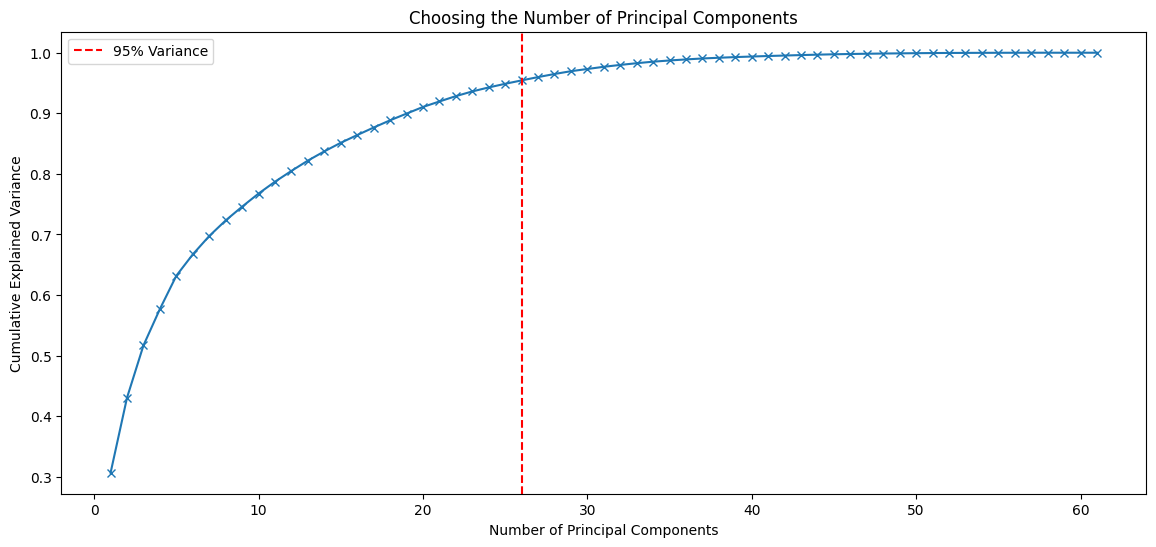

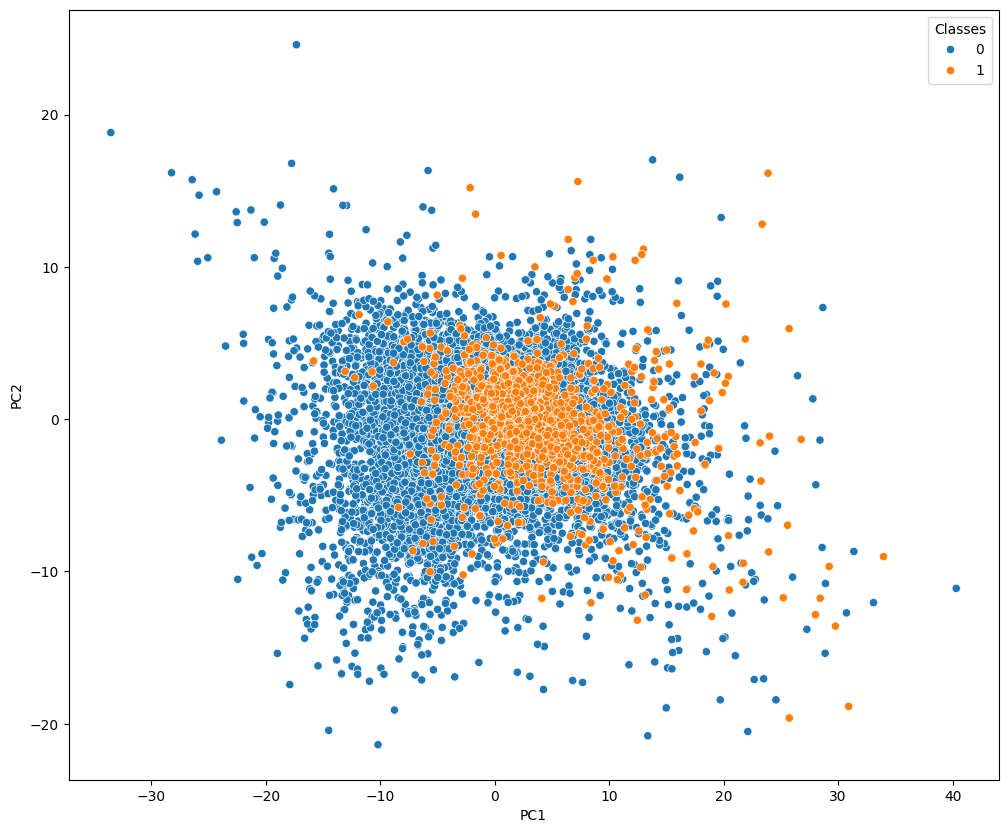

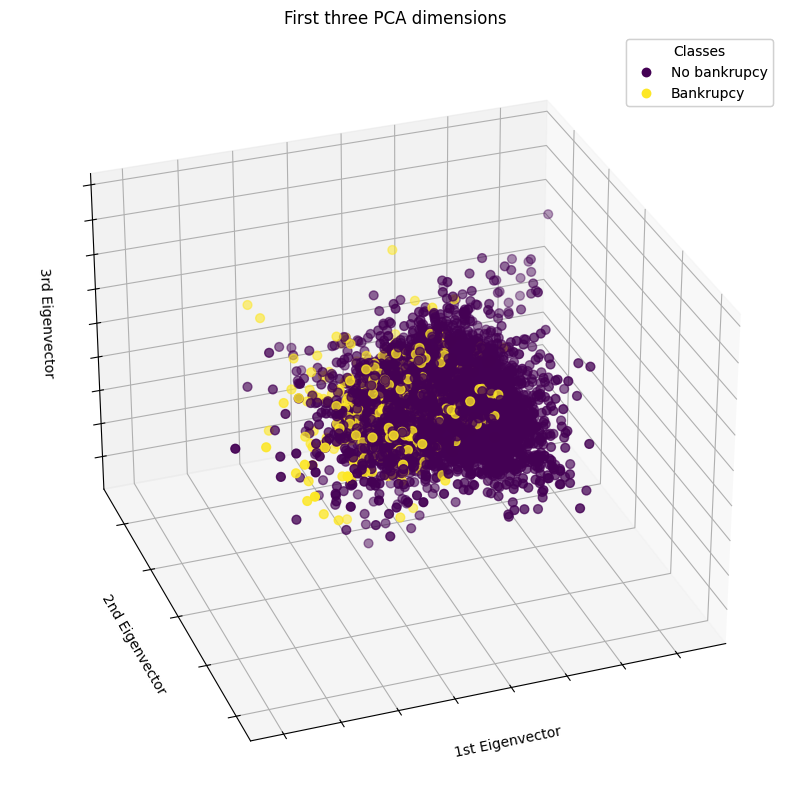

In [637]:
pca_df = scaled_df.drop("class", axis=1)
y = scaled_df["class"]

pca_all = PCA()
_ = pca_all.fit_transform(pca_df)

explained_variance = np.cumsum(pca_all.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1
pca = PCA(n_components)
X_reduced = pca.fit_transform(pca_df)

plt.figure(figsize=(14, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='x')
plt.axvline(n_components, color='r', linestyle='--', label=f'95% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Choosing the Number of Principal Components')
plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_reduced[:, 0].flatten(), y=X_reduced[:, 1].flatten(), hue=y.astype(str))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Classes')
plt.show()

fig = plt.figure(1, figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    s=40,
)

ax.set(
title="First three PCA dimensions",
xlabel="1st Eigenvector",
ylabel="2nd Eigenvector",
zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

legend1 = ax.legend(
    scatter.legend_elements()[0],
    ["No bankrupcy", "Bankrupcy"],
    loc="upper right",
    title="Classes",
)
ax.add_artist(legend1)

plt.show()

### 3.2 Użycie t-SNE i analiza wyników

Przeprowazono liczne eksperymenty dla t-SNE. Część eksperymentów dla danych preprocesowanych, część eksperymentów dla danych po PCA.

Niestety obydwa podejścia mimo zmiany hiperparametru perplexity ukazywały bardzo wysokie wartości divergance - rozbierzności. 

Dla danych preprocesowanych oraz skalowanych osiągnięto divergence na poziomie 1.78 dla perplexities 500.

Dla danych po PCA osiągnięto divergence na poziomie 2.0 dla perplexity 300.

Oznacza to bardzo małą możliwość separowalnośći klas przez TSNE. Wartość oczekiwana divergence znajduje się poniżej 1 dla niższych perplexities.

Finalny wykres dla najlepiej sprawujących się danych i hiperparametrów nie ukazał definitywnego podziału, lecz mona zaobserowwać, iż klasa 1 posiada tendencje do klastrowania się po prawej stronie First tSNE oraz w centrum second tSNE. 

Wizualizacje nie umożliwiły klarownego odseparowania klas.

In [ ]:
perplexities = np.linspace(30, 200, 5)
divergence = []

for i, perplexity in enumerate(perplexities):
    print(f'{i+1}/{len(perplexities)} - perplexity: {int(perplexity)}')
    model = TSNE(n_components=2, init="pca", perplexity=int(perplexity))
    reduced = model.fit_transform(pca_df)
    divergence.append(model.kl_divergence_)

1/5 - perplexity: 30
2/5 - perplexity: 72
3/5 - perplexity: 115
4/5 - perplexity: 157
5/5 - perplexity: 200


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


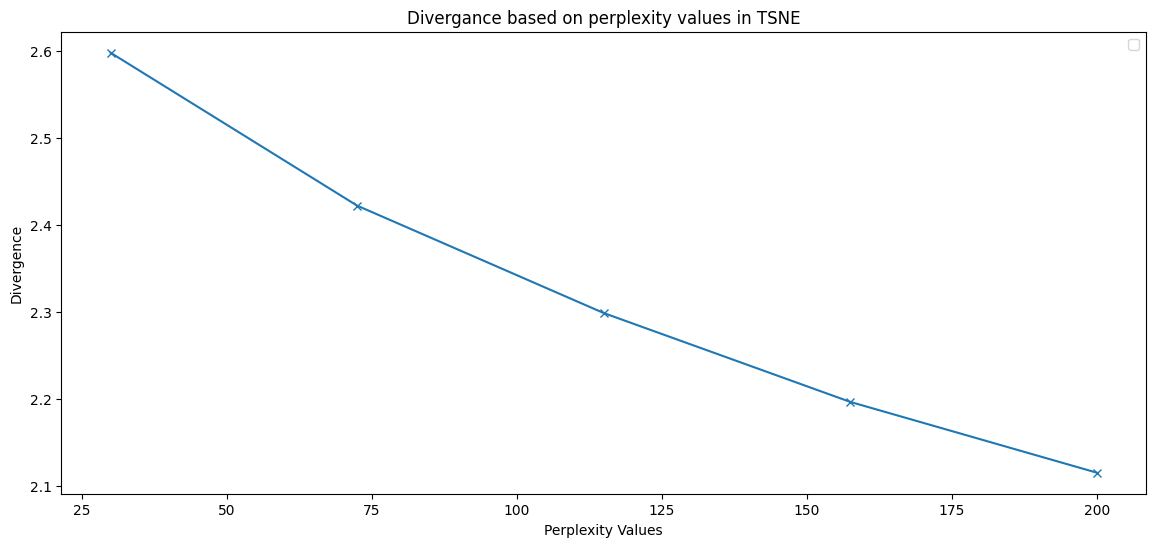

In [576]:
plt.figure(figsize=(14, 6))
plt.plot(perplexities, divergence, marker='x')
plt.xlabel('Perplexity Values')
plt.ylabel('Divergence')
plt.title('Divergance based on perplexity values in TSNE')
plt.legend()
plt.show()

In [578]:
perplexities = np.linspace(30, 300, 5)
divergence = []

for i, perplexity in enumerate(perplexities):
    print(f'{i+1}/{len(perplexities)} - perplexity: {perplexity}')
    model = TSNE(n_components=2, init="pca", perplexity=perplexity)
    reduced = model.fit_transform(X_reduced)
    divergence.append(model.kl_divergence_)

1/5 - perplexity: 30.0
2/5 - perplexity: 97.5
3/5 - perplexity: 165.0
4/5 - perplexity: 232.5
5/5 - perplexity: 300.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


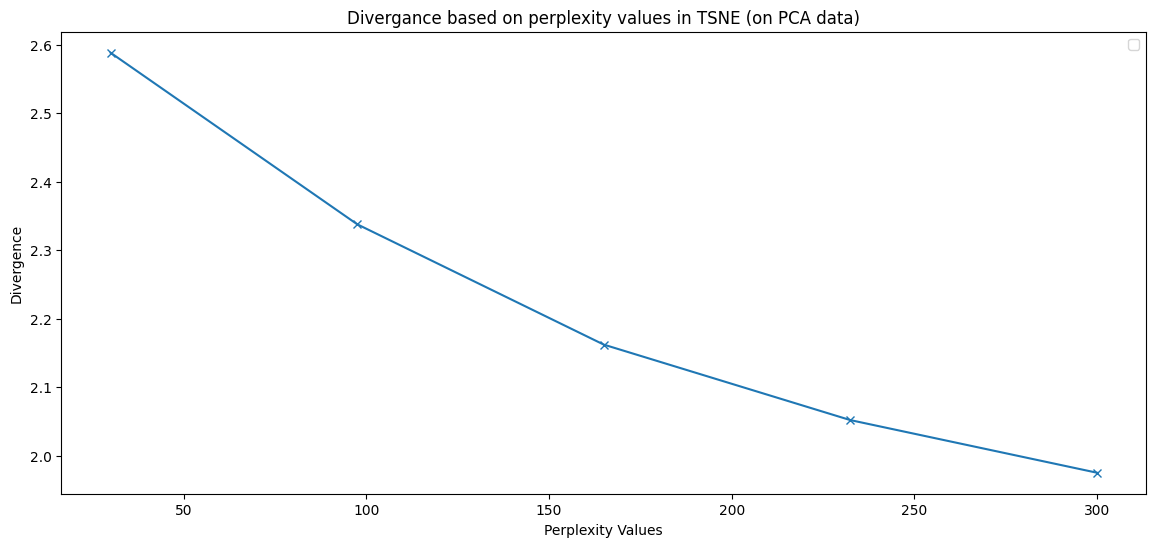

In [579]:
plt.figure(figsize=(14, 6))
plt.plot(perplexities, divergence, marker='x')
plt.xlabel('Perplexity Values')
plt.ylabel('Divergence')
plt.title('Divergance based on perplexity values in TSNE (on PCA data)')
plt.legend()
plt.show()

In [580]:
perplexities = np.linspace(350, 500, 3)
divergence = []

for i, perplexity in enumerate(perplexities):
    print(f'{i+1}/{len(perplexities)} - perplexity: {int(perplexity)}')
    model = TSNE(n_components=2, init="pca", perplexity=int(perplexity))
    reduced = model.fit_transform(pca_df)
    divergence.append(model.kl_divergence_)

1/3 - perplexity: 350
2/3 - perplexity: 425
3/3 - perplexity: 500


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


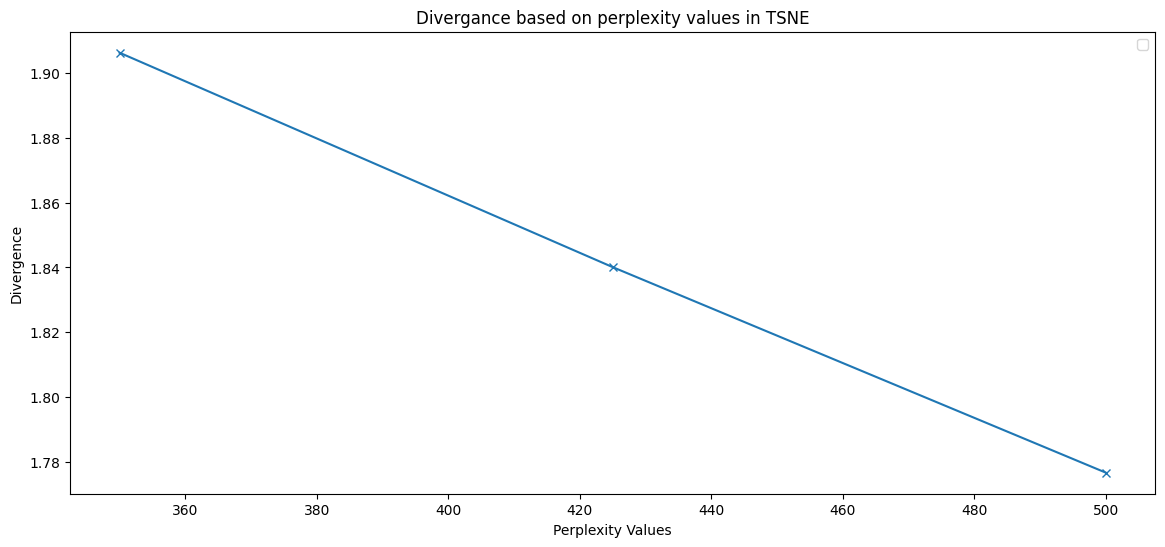

In [582]:
plt.figure(figsize=(14, 6))
plt.plot(perplexities, divergence, marker='x')
plt.xlabel('Perplexity Values')
plt.ylabel('Divergence')
plt.title('Divergance based on perplexity values in TSNE')
plt.legend()
plt.show()

Zdecydowano się na 2 komponenty przy perplexity 400 oraz danych preprocesowanych i skalowanych, ponieważ uzyskiwały najlepszy wynik divergence

In [648]:
tsne = TSNE(n_components=2, perplexity=400, random_state=42)
X_train_tsne = tsne.fit_transform(pca_df)

tsne.kl_divergence_

1.9757237434387207

*wykres opisany na początku sekcji 3.2*

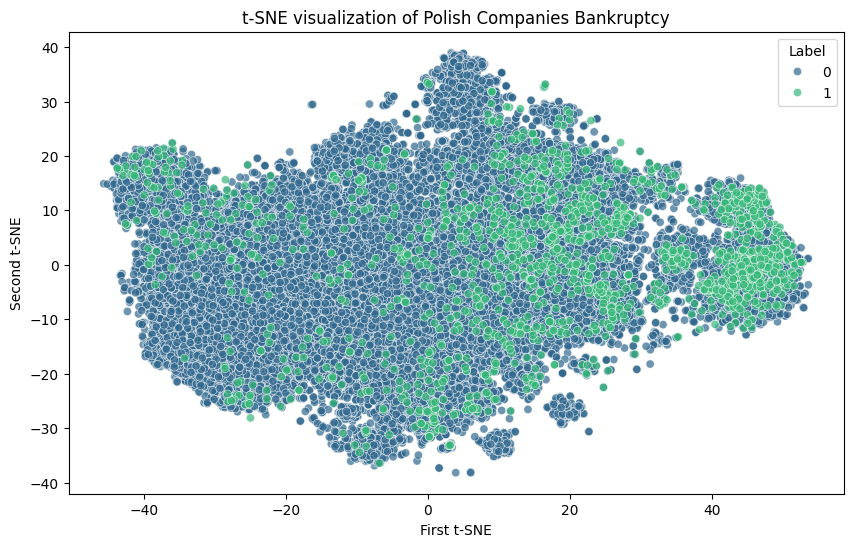

In [652]:
tsne_df = pd.DataFrame({
    'First t-SNE': X_train_tsne[:, 0],
    'Second t-SNE': X_train_tsne[:, 1],
    'Label': y.to_numpy().ravel()
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='First t-SNE', y='Second t-SNE', hue='Label', palette='viridis', alpha=0.7)

plt.title("t-SNE visualization of Polish Companies Bankruptcy")
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
plt.legend(title="Label")
plt.show()

## 4. Przygotowanie zbioru dla budowy modelu.

In [24]:
preprocessed_df

A1       A2        A3       A4        A5       A6        A7  \
0      0.209120  0.49988  0.472250  1.94470   14.7860  0.00000  0.258340   
1      0.248660  0.69592  0.267130  1.55480   -1.1523  0.00000  0.309060   
2      0.081483  0.30734  0.458790  2.49280   51.9520  0.14988  0.092704   
3      0.187320  0.61323  0.229600  1.40630   -7.3128  0.18732  0.187320   
4      0.228220  0.49794  0.359690  1.75020  -47.7170  0.00000  0.281390   
...         ...      ...       ...      ...       ...      ...       ...   
38798  0.012898  0.70621  0.038857  1.17220  -18.9070  0.00000  0.013981   
38799 -0.578050  0.96702 -0.800850  0.16576  -67.3650 -0.57805 -0.578050   
38800 -0.179050  1.25530 -0.275990  0.74554 -120.4400 -0.17905 -0.154930   
38801 -0.108860  0.74394  0.015449  1.08780  -17.0030 -0.10886 -0.109180   
38802 -0.105370  0.53629 -0.045578  0.91478  -56.0680 -0.10537 -0.109940   

            A8       A9       A10  ...       A56       A57      A58       A59  \
0      0.99601  1.69960  0.497880  ...  0.121300  0.420020  0.85300  0.000000   
1      0.43695  1.30900  0.304080  ...  0.241140  0.817740  0.76599  0.694840   
2      1.86610  1.05710  0.573530  ...  0.054015  0.142070  0.94598  0.000000   
3      0.63070  1.15590  0.386770  ...  0.134850  0.484310  0.86515  0.124440   
4      1.00830  1.97860  0.502060  ...  0.139320  0.454570  0.85891  0.023002   
...        ...      ...       ...  ...       ...       ...      ...       ...   
38798  0.41600  1.67680  0.293790  ...  0.020169  0.043904  1.01220  1.259400   
38799 -0.40334  0.93979 -0.390040  ... -0.064073  1.482000  1.06410 -0.018084   
38800 -0.26018  1.17490 -0.326590  ...  0.148880  0.548240  0.85112 -0.522430   
38801  0.12531  0.84516  0.093224  ... -0.183200 -1.167700  1.18320  6.092400   
38802  0.86460  0.95040  0.463670  ... -0.052186 -0.227250  1.05220  0.003196   

            A60      A61      A62     A63       A64  class  
0        4.1486   3.2732  107.350  3.4000  60.98700      0  
1        4.9909   3.9510  134.270  2.7185   5.20780      0  
2        4.5746   3.6147   86.435  4.2228   5.54970      0  
3        6.3985   4.3158  127.210  2.8692   7.89800      0  
4        3.4028   8.9949   88.444  4.1269  12.29900      0  
...         ...      ...      ...     ...       ...    ...  
38798   13.4720  12.4320   49.117  7.4313   2.27990      1  
38799  110.7200  44.7590   81.220  4.4940   5.13050      1  
38800    9.8526   3.4892  207.870  1.7559   9.95270      1  
38801   13.8860   6.0769   83.122  4.3911   0.95575      1  
38802    7.7332   4.7174  136.850  2.6672   2.79270      1  

[38803 rows x 62 columns]

Dane podzielono według 80/20 split. W zbiorze testowym znalazło się tym samym 7398 instancji klasy 0 oraz 363 instancji klasy 1. Ukazuje się tu uwcześnie zaobserwowana dysproporcja w rozkładzie klas. 

By rozwiązać ten problem, nie przesadzając, zdecydowano się na SMOTE oraz oversampling - metody zwiększania liczności klasy 1, które miały na celu zmniejszyć różnice w reprezentacji.

Ze względu na kolosalną przepaść w licznościach zdecydowano się ustawić parametr sampling_strategy na 15%, aby nie zostało dorobione zbyt wiele danych. Mimo to zbiór labelów 1 zwiększył się, aż 10 krotnie, co mogło doprowadzić do nadmiernej produkcji sztucznych danych.

Aby to zbadać zdecydowano się przeprowadzać eksperymenty na wszyskich 3 podejściach.

In [25]:
X = preprocessed_df.drop("class", axis=1)
y = preprocessed_df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
y_test.value_counts()

class
0    7398
1     363
Name: count, dtype: int64

SMOTE działa poprzez wybranie rekordów, które są blisko siebie w przestrzeni cech, narysowanie linii między przykładami w przestrzeni cech i narysowanie nowej próbki w punkcie wzdłuż tej linii.

In [28]:
smote = SMOTE(sampling_strategy=0.15, random_state=42) 
X_train_balanced_smote, y_train_balanced_smote = smote.fit_resample(X_train_scaled, y_train,)
y_train_balanced_smote.value_counts()

class
0    29592
1     4438
Name: count, dtype: int64

RandomOverSampler duplikuje rekordy w trywialny sposób, przekopiowując je powodując wielokrotne występowania w celu zwiększenia znaczenia nielicnzych rekordów

In [29]:
oversampler = RandomOverSampler(sampling_strategy=0.15, random_state=42)
X_train_balanced_oversampler, y_train_balanced_oversampler = oversampler.fit_resample(X_train_scaled, y_train)
y_train_balanced_oversampler.value_counts()

class
0    29592
1     4438
Name: count, dtype: int64

## 5. Uruchomienie 2 wybranych modeli klasyfikacji lub grupowania oraz analiza wyników oraz wpływu decyzji podjętych w obszarze czyszczenia zbioru.


### 5.1 Uruchomienie modelu xgb

*Na podstawie pracy naukowej załączonej do zadania zdecydowano się ewaluować modele za pomocą AUC*

Due to the imbalanced nature of training data, we utilized the Area Under ROC Curve (AUC) curve criterion to evaluate the quality of the models.

~ Maciej Zięba, Sebastian K. Tomczak, Jakub M. Tomczak

XGBoost to implementacja algorytmu boostingowego, w którym modele (np.  drzewa decyzyjne) są budowane sekwencyjnie, a każdy kolejny model stara się poprawić błędy popełnione przez poprzednie. Wykorzystuje on funkcję kosztu i optymalizację gradientową. Z kolei AUC-ROC (Area Under the Receiver Operating Characteristic Curve) to popularna metryka oceny modelu w zadaniach klasyfikacji binarnej. Mierzy ona zdolność modelu do rozróżniania między dwiema klasami, niezależnie od progu decyzji.

XGradientBoost jest pierwszym wykorzystanym do zadania klasyfikatorem. Jego zaletami jest ogromna prędkość trenowania, bardzo wysoka skuteczność, nie jest czuły na brak balansu klas. Powyższe powody stały się podstawą, ku wybraniu tego algorytmu.

Następnie, by zwiększyć jakość rozwiązania zastosowano GridSearch, który testuje wybrany model z różnymi parametrami, następnie wybierając najlepszy.

Najlepszymi parametrami dla danych prepreocesowanych okazało się:

'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 20.408275862068965, 'subsample': 0.8

In [881]:
def train_evaluate_xgb(X_train, y_train, X_test, y_test, dataset_name):
    print(f"Training XGBoost on: {dataset_name}")
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'scale_pos_weight': [scale_pos_weight]
    }

    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic', 
        eval_metric='auc', 
        use_label_encoder=False
    )

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=10,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Najlepsze parametry dla {dataset_name}: {grid_search.best_params_}")

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"AUC-ROC dla {dataset_name}: {auc_score:.4f}")

    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMacierz konfuzji dla {dataset_name}:\n{cm}")

    print(f"\nClassification Report dla {dataset_name}:\n")
    print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

    return best_model, auc_score, grid_search.cv_results_

Pierwszy test został dokonany na danych preprocesowanych bez dodawania reprezentanów klasy 1. 

Model osiągnął AUC-ROC na poziomie 94,3%

Macierz konfuzji ukazała, iż znaczna większość reprezentantów klasy 0 została prawidłowo sklasyfikowana, lecz jedynie 60% reprezentatnów klasy 1 zostało prawidłowo sklasyfikowane.

Model posiada accuracy na poziomie 96%, lecz nie jest to najważniejsza miara, ponieważ trudnością klasyfikacji jest prawidłowe sklasyfikowanie rekordów o klasie 1. Dla rekordów o klasie 0 zadanie jest trywianlne, ponieważ posiada znacznie więcej reprezentantów.

In [882]:
model_original, auc_original, results_original = train_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, "Oryginalny zbiór")

Training XGBoost on: Oryginalny zbiór
Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\mikja\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Najlepsze parametry dla Oryginalny zbiór: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 20.408275862068965, 'subsample': 0.8}
AUC-ROC dla Oryginalny zbiór: 0.9434

Macierz konfuzji dla Oryginalny zbiór:
[[7261  137]
 [ 164  199]]

Classification Report dla Oryginalny zbiór:

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      7398
     Class 1       0.59      0.55      0.57       363

    accuracy                           0.96      7761
   macro avg       0.79      0.76      0.77      7761
weighted avg       0.96      0.96      0.96      7761



Drugi model z augmentacją danych SMOTE - zwiększeniem reprezentantów class 1 poradził sobię trochę lepiej znajdując więcej reprezentantów tej klasy.

Wynik AUC-ROC wynosi ponownie 94,3%, lecz macierz konfuzcji ukazała aż 10 dodatkowych prawidłowo sklasyfikowanych rekordów. Tym razem model także częściej mylił klasę 0 z klasą 1, aż 184 rekordy z klasą 0 zostały zklasyfikowane jako klasa 1.

Jest to znacznie lepszy model, ponieważ zależy nam na dokładniejszym wykrywaniu potencjalnych bankructw.

In [883]:
model_smote, auc_smote, results_smote = train_evaluate_xgb(X_train_balanced_smote, y_train_balanced_smote, X_test_scaled, y_test, "SMOTE")

Training XGBoost on: SMOTE
Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\mikja\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Najlepsze parametry dla SMOTE: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 6.66786840919333, 'subsample': 0.8}
AUC-ROC dla SMOTE: 0.9434

Macierz konfuzji dla SMOTE:
[[7216  182]
 [ 154  209]]

Classification Report dla SMOTE:

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      7398
     Class 1       0.53      0.58      0.55       363

    accuracy                           0.96      7761
   macro avg       0.76      0.78      0.77      7761
weighted avg       0.96      0.96      0.96      7761



Ostatni model, który został przygotowany z metodą oversamplingu ukazał także lepsze umiejętności w znajdywaniu rekordów klasy 1, lecz gorsze niż model SMOTE.

AUC wyniosło 94,5%, dając wyższy wynik niż poprzednie klasyfikatory, dzięki częstszemu prawidłowemu klasyfikowaniu klas 0. 

In [884]:
model_oversample, auc_oversample, results_oversample = train_evaluate_xgb(X_train_balanced_oversampler, y_train_balanced_oversampler, X_test_scaled, y_test, "Oversampling")

Training XGBoost on: Oversampling
Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\mikja\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:09:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Najlepsze parametry dla Oversampling: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 6.66786840919333, 'subsample': 0.8}
AUC-ROC dla Oversampling: 0.9450

Macierz konfuzji dla Oversampling:
[[7269  129]
 [ 159  204]]

Classification Report dla Oversampling:

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      7398
     Class 1       0.61      0.56      0.59       363

    accuracy                           0.96      7761
   macro avg       0.80      0.77      0.78      7761
weighted avg       0.96      0.96      0.96      7761



Moment przytłaczającej rzeczywistości - model zbudowany na podstawie oryginalnch danych poradził sobie najlepiej z zadaniem.

Prawidłowo zklasyfikował aż 295 rekordów przy AUC-KOC równym 97,4%

Model ten radzi sobie najlepiej spośród wszystkich dotychczasowych, mimo brakujących rekordów, wartości odstających, braku skalowania oraz zachowania bezużytecznych kolumn.

In [885]:
X = polish_companies_bankruptcy.data.original.drop(["year", "class"], axis=1)
y = polish_companies_bankruptcy.data.original["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model_raw_data, auc_raw_data, results_raw_data = train_evaluate_xgb(X_train, y_train, X_test, y_test, "Raw Data")

Training XGBoost on: Raw Data
Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\mikja\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:10:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Najlepsze parametry dla Raw Data: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 19.755528989838613, 'subsample': 1.0}
AUC-ROC dla Raw Data: 0.9742

Macierz konfuzji dla Raw Data:
[[8189   74]
 [ 123  295]]

Classification Report dla Raw Data:

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99      8263
     Class 1       0.80      0.71      0.75       418

    accuracy                           0.98      8681
   macro avg       0.89      0.85      0.87      8681
weighted avg       0.98      0.98      0.98      8681



### 5.2 Uruchomienie modelu Random Forest

Random Forest to model oparty na metodzie lasów losowych, gdzie tworzonych jest wiele drzew decyzyjnych, z których każde analizuje losowy podzbiór danych i cech. Końcowa decyzja jest podejmowana na podstawie głosowania większościowego.

Ponownie jak dla XGBoost zastosowano Grid search w celu znalezienia najlepszych parametrów dla modelu oraz metrykę do ewaluacji jako AUC.

In [35]:
def train_evaluate_rf(X_train, y_train, X_test, y_test, dataset_name):
    print(f"Training Random Forest on: {dataset_name}")

    param_grid = {
        'n_estimators': [300, 500],
        'max_depth': [None, 20],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [4, 8],
        'bootstrap': [False]
    }

    rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=10,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Najlepsze parametry dla {dataset_name}: {grid_search.best_params_}")

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"AUC-ROC dla {dataset_name}: {auc_score:.4f}")

    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMacierz konfuzji dla {dataset_name}:\n{cm}")

    print(f"\nClassification Report dla {dataset_name}:\n")
    print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

    return best_model, auc_score, grid_search.cv_results_


Pierwszy test został dokonany na danych preprocesowanych bez dodawania reprezentantów klasy 1.  

Model osiągnął AUC-ROC na poziomie 91,6%, co wskazuje na dobrą, choć nieco gorszą niż w poprzednim modelu, zdolność do odróżniania klas.  

Macierz konfuzji ukazała, że znaczna większość reprezentantów klasy 0 została prawidłowo sklasyfikowana, z 99% skutecznością, jednak tylko 21% reprezentantów klasy 1 zostało prawidłowo sklasyfikowanych. Oznacza to, że model ma duże problemy z wykrywaniem mniejszej klasy.  

Model posiada accuracy na poziomie 96%, lecz — podobnie jak w poprzednim przypadku — nie jest to najważniejsza miara, ponieważ główną trudnością jest prawidłowe sklasyfikowanie rekordów o klasie 1. Dla rekordów o klasie 0 zadanie jest trywialne ze względu na znacznie większą liczbę przykładów.  

Niski recall i f1 dla klasy 1 (odpowiednio 0.21 i 0.31) potwierdzają, że model często pomija reprezentantów tej klasy, co czyni go mniej użytecznym w przypadku niezbalansowanych danych.

In [33]:
model_original_rf, auc_original_rf, results_original_rf = train_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test, "Oryginalny zbiór")

Training Random Forest on: Oryginalny zbiór
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Najlepsze parametry dla Oryginalny zbiór: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
AUC-ROC dla Oryginalny zbiór: 0.9158

Macierz konfuzji dla Oryginalny zbiór:
[[7339   59]
 [ 287   76]]

Classification Report dla Oryginalny zbiór:

              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.98      7398
     Class 1       0.56      0.21      0.31       363

    accuracy                           0.96      7761
   macro avg       0.76      0.60      0.64      7761
weighted avg       0.94      0.96      0.95      7761



Test został przeprowadzony na danych z dodatkową augmentacją rekordów dla klasy 1 metodą SMOTE, mającą na celu zbalansowanie zbioru.

Macierz konfuzji pokazała, że większość przykładów klasy 0 została poprawnie sklasyfikowana, natomiast jedynie 30% przykładów klasy 1 zostało wykrytych prawidłowo. Model wciąż pomija znaczną część mniej licznej klasy, mimo zastosowania augmentacji.

SMOTE pomogło nieznacznie poprawić wyniki w porównaniu z modelem bez augmentacji, lecz problem z niskim recall wciąż pozostaje wyzwaniem.

In [36]:
model_smote_rf, auc_smote_rf, results_smote_rf = train_evaluate_rf(X_train_balanced_smote, y_train_balanced_smote, X_test_scaled, y_test, "SMOTE")

Training Random Forest on: SMOTE
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Najlepsze parametry dla SMOTE: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
AUC-ROC dla SMOTE: 0.9154

Macierz konfuzji dla SMOTE:
[[7290  108]
 [ 255  108]]

Classification Report dla SMOTE:

              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98      7398
     Class 1       0.50      0.30      0.37       363

    accuracy                           0.95      7761
   macro avg       0.73      0.64      0.67      7761
weighted avg       0.94      0.95      0.95      7761



In [37]:
model_oversample_rf, auc_oversample_rf, results_oversample_rf = train_evaluate_rf(X_train_balanced_oversampler, y_train_balanced_oversampler, X_test_scaled, y_test, "Oversampling")

Training Random Forest on: Oversampling
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Najlepsze parametry dla Oversampling: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 300}
AUC-ROC dla Oversampling: 0.9095

Macierz konfuzji dla Oversampling:
[[7343   55]
 [ 288   75]]

Classification Report dla Oversampling:

              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.98      7398
     Class 1       0.58      0.21      0.30       363

    accuracy                           0.96      7761
   macro avg       0.77      0.60      0.64      7761
weighted avg       0.94      0.96      0.95      7761



### 5.3 Analiza wyników modeli

Porównując modele XGBoost i Random Forest, widać wyraźnie, że XGBoost lepiej radzi sobie z wykrywaniem rzadszej klasy 1. Najlepszy wynik uzyskano na surowych danych, gdzie AUC-ROC wyniósł 97,4%, a model poprawnie sklasyfikował 295 rekordów klasy 1.

Augmentacja danych metodą SMOTE w przypadku XGBoost też dała dobre efekty — o 10 więcej poprawnych klasyfikacji niż na danych oryginalnych, mimo tej samej wartości AUC-ROC (94,3%). Widać lepsze wykrywanie klasy 1, ale kosztem większej liczby błędów przy klasyfikacji klasy 0. Oversampling z kolei lekko poprawił AUC-ROC do 94,5%, ale model był mniej skuteczny w znajdowaniu rekordów klasy 1 w porównaniu do SMOTE.

Random Forest wypadł gorzej, wersja na preprocesowanych danych osiągnęła AUC-ROC na poziomie 91,6%, ale poprawnie sklasyfikowała tylko 76 rekordów klasy 1. To bardzo słaby wynik przy takim ogólnym accuracy. Zastosowanie SMOTE poprawiło ten wynik do 108 poprawnych klasyfikacji, co jest postępem, ale wciąż znacząco odbiega od rezultatów XGBoost.

Podsumowując, XGBoost wygrywa w każdym scenariuszu. Surowe dane dają mu najlepszy wynik całościowo, ale SMOTE pozwala na lepsze wykrywanie klasy 1 w przypadku bardziej wyrównanego podziału. Random Forest wypada słabiej, a nawet po zastosowaniu SMOTE wciąż ma duże problemy z klasyfikacją mniej licznej klasy.

## 6. Podsumowanie

W projekcie przeanalizowano zbiór "Polish Companies Bankruptcy", zawierający informacje o polskich przedsiębiorstwach, które zbankrutowały na przestrzeni pięciu lat. Głównym celem było dokonanie analizy, przetworzenie danych, zwizualizowanie ich za pomocą PCA oraz tSNE oraz zbudowanie modeli predykcyjnych oraz ocena ich skuteczności w klasyfikacji firm na te zagrożone bankructwem i te działające stabilnie.

W pierwszej kolejności została przeprowadzona analiza zbiorów, gdzie wykryto nierówną reprezentację firm zbankrutowanych oraz prawidłowo prosperujących, pewne zależności miedzy kolumnami jak i najważniejsze atrybuty i najmniej przydatne w zbiorze.

Następnie proces modelowania rozpoczął się czyszczeniem danych: usunięcie wartości odstających, uzupełnienie braków, skalowaniem.

Następnie przeprowadzono redukcję wymiarów za pomocą PCA i t-SNE, co umożliwiło teoretycznie lepszą, lecz praktycznie mało ukazującą wizualizację struktury danych.

Wytrenowano kilka modeli klasyfikacyjnych - XGBoost i Random Forest, zarówno na oryginalnych danych, jak i na zbiorach zbalansowanych metodami SMOTE i oversamplingu. Porównanie wyników pokazało, że choć ogólna dokładność była wysoka, głównym wyzwaniem pozostawało skuteczne wykrywanie mniejszej klasy (bankructwa).

Najlepsze wyniki uzyskano na surowych danych bez intensywnej preprocesji, co sugeruje, iż przetwarzanie oraz rozumienie danych zostało wykonane w sposób skrajnie ubogi, badź że czasem mniej agresywne podejście do czyszczenia danych może przynieść lepsze rezultaty w złożonych zadaniach klasyfikacyjnych.

**Informacja na marginesie / prośba**

Uważam, że przez okrutnie trudny zbiór danych student i mniej mógł się nauczyć i mniej mógł się nacieszyć procesem modelowania i analizowania.

Zważywszy, iż problem ten był rozpatrywany przez Profesorów w pracy naukowej i określony jako naprawdę trudny sądzę, iż jest to bardzo nieodpowiedni zbiór danych na 2 listę laboratorium z Uczenia Maszynowego na 1 semestrze :(

Jestem przekonany, iż wzięcie łatwiejszego (nie łatwego) datastu umozliwiłoby studentom w lepszy sposób zrozumieć siłę preprocesingu, ujrzeć lepiej jak działa TSNE oraz móc pobawić się na prostszych modelach jednocześnie uzyskując adekwatne wyniki.

Osobiście spędziłem nad tą listą bardzo dużo godzin i dobrze się bawiłem, lecz z pewnością nauczył bym się więcej i zrozumiał lepiej co dały moje decyzje, gdybym mógł je sprawdzić na innym zbiorze danych.